# Evaluate gene2vec from PubMed abstracts from AutoRIF

Training of Word2Vec model was done in [this notebook](Train-word2vec-on-AutoRIF-PMIDs.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

import w2v_utils

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
from wordcloud import WordCloud
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [3]:
model = Word2Vec.load('../data/models/word2vec-3000000-docs-100-dims.model') 

In [4]:
# Load trained w2v model
wv_mat, vocab_df = w2v_utils.parse_model(model)
print(wv_mat.shape, vocab_df.shape)

(23569, 3)
(20069, 2)
(180954, 100) (180954, 5)


In [5]:
vocab_df.head()

index       token gene     count        word
0      0   searching  NaN      5110   searching
1      1   biomarker  NaN     51147   biomarker
2      2  candidates  NaN     24592  candidates
3      3          in  NaN  21943868          in
4      4       serum  NaN    576918       serum

In [6]:
# remove stopwords
vocab_df_filt = vocab_df.loc[~vocab_df['word'].isin(ENGLISH_STOP_WORDS)]
vocab_df_filt.shape

(180649, 5)

In [7]:
vocab_df_filt['frequency'] = vocab_df_filt['count'] / vocab_df_filt['count'].sum()

/Users/maayanlab/Documents/Zichen_Projects/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
d_word_freq = dict(zip(vocab_df_filt['word'], vocab_df_filt['frequency']))

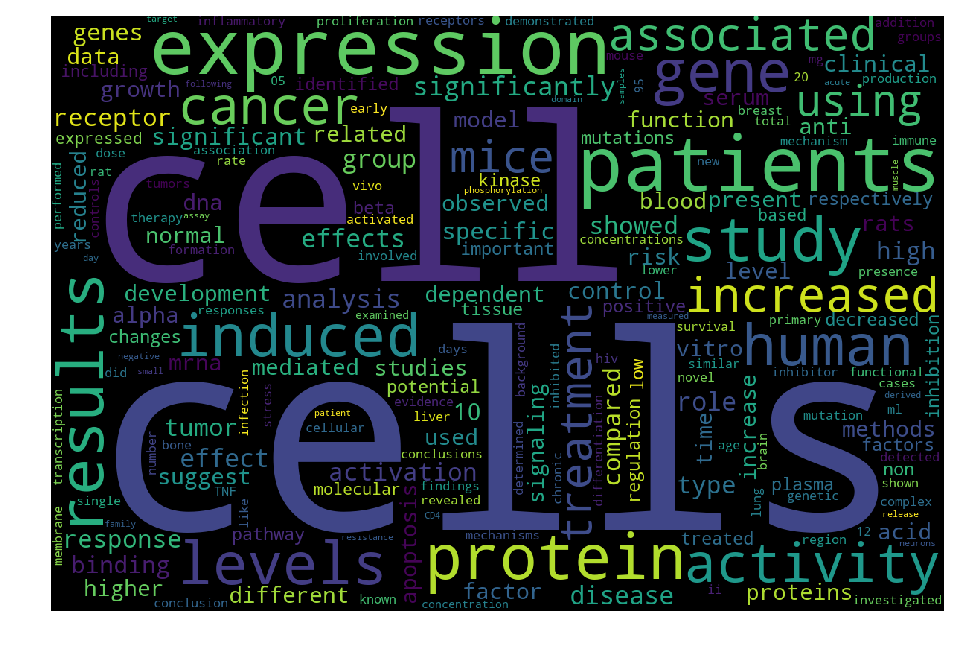

In [9]:
fig, ax = plt.subplots(figsize=(16,16))
wordcloud = WordCloud(width=1200, height=800, 
                      stopwords=ENGLISH_STOP_WORDS).generate_from_frequencies(d_word_freq)
ax.imshow(wordcloud)
ax.axis("off");

# Qualitative evaluations

Examine word/gene vectors

In [10]:
d_serialno_gene = w2v_utils.load_serialno_gene_symbol_dict()

(23569, 3)
(20069, 2)


In [11]:
# Number of genes with vectors
vocab_df.loc[~vocab_df.gene.isnull()].shape

(15090, 5)

In [28]:
def wrap_most_similar_results(**kwargs):
    res = model.wv.most_similar(**kwargs)
    res = pd.DataFrame(res, columns=['token', 'cosine_similarity'])
    return res.merge(vocab_df, left_on='token', right_on='token').set_index('token')

def wrap_gene_search(gene_symbol):
    gene_id = vocab_df.query('gene == "%s"' % gene_symbol).iloc[0]['token']
    res = model.wv.most_similar(gene_id)
    res = pd.DataFrame(res, columns=['token', 'cosine_similarity'])
    return res.merge(vocab_df, left_on='token', right_on='token').set_index('token')

def wrap_gene_search_analogy(positive_symbols=[], negative_symbols=[], topn=10):
    gene_ids_pos = vocab_df.loc[vocab_df['word'].isin(positive_symbols), 'token'].tolist()
    gene_ids_neg = vocab_df.loc[vocab_df['word'].isin(negative_symbols), 'token'].tolist()
    
    res = model.wv.most_similar(positive=gene_ids_pos, negative=gene_ids_neg, topn=topn)
    res = pd.DataFrame(res, columns=['token', 'cosine_similarity'])
    return res.merge(vocab_df, left_on='token', right_on='token').set_index('token')

## Word vectors

In [12]:
wrap_most_similar_results(positive='cell')

cosine_similarity   index gene    count           word
token                                                                
cells                   0.658794     109  NaN  4139061          cells
lymphocyte              0.638318    2954  NaN    89350     lymphocyte
tcell                   0.594914  116951  NaN      200          tcell
keratinocyte            0.587459    8077  NaN    12344   keratinocyte
tec                     0.569734   14681  NaN     3534            tec
cellular                0.553465    1131  NaN   326092       cellular
thymocyte               0.545120   23299  NaN     7665      thymocyte
cholangiocyte           0.538973   21375  NaN     1007  cholangiocyte
intraperiod             0.536085   69240  NaN       31    intraperiod
blaschko                0.523187   64326  NaN       80       blaschko

In [13]:
wrap_most_similar_results(positive='gene', topn=20)

cosine_similarity   index   gene   count           word
token                                                                 
genes                   0.734158     394    NaN  755039          genes
locus                   0.593843     322    NaN   84878          locus
cdna                    0.581321    2095    NaN   90990           cdna
protooncogene           0.569464   24857    NaN    2307  protooncogene
transgene               0.564061    3471    NaN   21022      transgene
promoter                0.543904    2010    NaN  252301       promoter
cdnas                   0.539466    2138    NaN   11229          cdnas
deltadnmt3b             0.529948   77916    NaN      30    deltadnmt3b
pyrbi                   0.518945  160359    NaN      36          pyrbi
transgenes              0.517721    8951    NaN    3917     transgenes
sdhcdab                 0.513665   77846    NaN      55        sdhcdab
multigene               0.513151    9710    NaN    2117      multigene
transcript              0.510445    3510    NaN   49792     transcript
isogenes                0.509131   32603    NaN      51       isogenes
oncogene                0.507346   13787    NaN   37240       oncogene
pcdhalpha               0.505012  131352    NaN      43      pcdhalpha
biallelic               0.504749   11331    NaN    4657      biallelic
1851742                 0.497526  155066  DHRS4      22          DHRS4
rosr                    0.497096  127230    NaN      44           rosr
1843311                 0.496516  156033   GNB4      33           GNB4

In [35]:
wrap_most_similar_results(positive='human', topn=20)

cosine_similarity   index gene   count             word
token                                                                   
murine                    0.750138    3311  NaN  135465           murine
canine                    0.724578    5530  NaN   24085           canine
porcine                   0.721148    2387  NaN   37564          porcine
bovine                    0.692587    2409  NaN   69268           bovine
mouse                     0.649786     947  NaN  403800            mouse
feline                    0.628223   21737  NaN    5768           feline
chicken                   0.624962    5899  NaN   28469          chicken
equine                    0.609800    1843  NaN    7894           equine
rat                       0.607714     329  NaN  398897              rat
rabbit                    0.578857    1842  NaN   45449           rabbit
rodent                    0.577929    1824  NaN   19634           rodent
ovine                     0.557583   12863  NaN   10129            ovine
avian                     0.539038    5872  NaN   11812            avian
derived                   0.512536     780  NaN  304250          derived
immortalized              0.509737    8628  NaN   12950     immortalized
nonimmortalized           0.509684   70391  NaN      61  nonimmortalized
t51b                      0.507144  138867  NaN      59             t51b
fibroblast                0.492322     846  NaN   40871       fibroblast
opossum                   0.485501    2264  NaN    1332          opossum
mammalian                 0.484831    1821  NaN   92597        mammalian

In [36]:
wrap_most_similar_results(positive='receptor')

cosine_similarity   index    gene   count             word
token                                                                      
receptors                 0.849028     871     NaN  387013        receptors
purinoreceptors           0.610104  100479     NaN      81  purinoreceptors
1851346                   0.600607  174986  GPR173      44           GPR173
p2yr                      0.596157   81924     NaN      50             p2yr
purinoceptor              0.578521   71805     NaN    1080     purinoceptor
recepter                  0.572011   81802     NaN      26         recepter
purinoreceptor            0.570677   51228     NaN      87   purinoreceptor
heteroreceptor            0.560513   84866     NaN     198   heteroreceptor
gpcr                      0.550515   16267     NaN    7298             gpcr
purinoceptors             0.549590   41580     NaN     887    purinoceptors

In [39]:
wrap_most_similar_results(positive=['cell', 'gene'], negative=['cells'])

cosine_similarity   index gene   count         word
token                                                           
rosr                  0.490580  127230  NaN      44         rosr
genes                 0.488200     394  NaN  755039        genes
multigene             0.474475    9710  NaN    2117    multigene
deltadnmt3b           0.471008   77916  NaN      30  deltadnmt3b
genomic               0.470019    1568  NaN   95942      genomic
genetic               0.467584      82  NaN  368484      genetic
dcta                  0.461278  128070  NaN     197         dcta
epigenetic            0.460733    3352  NaN   43844   epigenetic
ydiv                  0.460169  152060  NaN      24         ydiv
cbbr                  0.458935  112837  NaN      24         cbbr

## Gene vectors

In [16]:
# most frequent genes
vocab_df.loc[~vocab_df['gene'].isnull()].sort_values('count', ascending=False).head(10)

index    token   gene   count   word
3182   3182  1859647    TNF  399933    TNF
2966   2966  1842167    CD4  303915    CD4
3620   3620  1844021    INS  256742    INS
6312   6312  1846071   TP53  244032   TP53
851     851  1844622    IL6  225119    IL6
8111   8111  1846433   EGFR  197553   EGFR
2969   2969  1846851   CD8A  168465   CD8A
3177   3177  1845323   IL1B  168363   IL1B
4541   4541  1855587  VEGFA  158726  VEGFA
2772   2772  1844339    CRP  153600    CRP

In [17]:
# least frequent genes
vocab_df.loc[~vocab_df['gene'].isnull()].sort_values('count', ascending=True).head(10)

index    token     gene  count     word
179273  179273  1860755    USP51     20    USP51
174602  174602  1860845   PCP4L1     20   PCP4L1
178885  178885  1850442    PELI3     20    PELI3
180901  180901  1860467  FAM19A1     20  FAM19A1
174749  174749  1852794     CTSD     20     CTSD
139003  139003  1843165   CREBL2     20   CREBL2
167148  167148  1853164   RNF220     20   RNF220
174931  174931  1850782  C5orf30     20  C5orf30
139284  139284  1845058    CEP76     20    CEP76
78490    78490  1842592  ATP6V1D     20  ATP6V1D

In [18]:
wrap_gene_search('TNF')

cosine_similarity  index   gene   count      word
token                                                      
1845323            0.886720   3177   IL1B  168363      IL1B
1844622            0.848873    851    IL6  225119       IL6
1845322            0.835437   5342   IL1A   22295      IL1A
tnf                0.801361  13292    NaN   30189       tnf
1860220            0.787282   5505   IL10  123170      IL10
1848838            0.784547   3178  CXCL8   72278     CXCL8
1846656            0.764510   8208   IL18   30957      IL18
1843366            0.756437  11733  IL1R1   16432     IL1R1
1843052            0.742178   1950   CCL2   65859      CCL2
ifngamma           0.730477   5344    NaN   15254  ifngamma

In [19]:
wrap_gene_search('INS')

cosine_similarity  index  gene   count        word
token                                                         
1859111              0.793958  12940   GCG   43289         GCG
gip                  0.744698  25151   NaN   11135         gip
insulin              0.730602   1648   NaN  117350     insulin
glucose              0.726818   3273   NaN  281278     glucose
1849542              0.718912   6375   LEP   66098         LEP
gh                   0.701106   2003   NaN   78809          gh
ffa                  0.678597   5074   NaN    7488         ffa
glucagon             0.676393  12936   NaN    1711    glucagon
proinsulin           0.656666  20895   NaN    2917  proinsulin
1848425              0.649256   2186  IGF1  105404        IGF1

In [20]:
wrap_gene_search('TP53')

cosine_similarity  index      gene  count      word
token                                                       
1860452           0.834055  15319      MDM2  27647      MDM2
1843727           0.815074  14330    CDKN1A  73985    CDKN1A
1857435           0.811814  14612   TP53BP1  20476   TP53BP1
1858126           0.806075  40336  ARHGAP24   5188  ARHGAP24
p53               0.778719  15113       NaN   5819       p53
prb               0.778079  32167       NaN   6255       prb
1852773           0.774371  18602    UBE2L3  10435    UBE2L3
1859469           0.773027  13497    CDKN2A  65381    CDKN2A
p21waf1           0.770501  37249       NaN   4364   p21waf1
1856752           0.761909    395       MYC  91497       MYC

In [40]:
wrap_gene_search('STAT3')

cosine_similarity  index    gene   count      word
token                                                       
1854090            0.844009  18853   STAT1   19662     STAT1
1852410            0.841962   1543  STAT5A   13605    STAT5A
1848133            0.777467   7791   STAT6    7950     STAT6
nfkappab           0.775989  14115     NaN   16485  nfkappab
1851228            0.768247   4354   SOCS3   10020     SOCS3
1857374            0.764322   3430    JAK2   24657      JAK2
1852652            0.759569  33898    JAK1    4627      JAK1
1846124            0.744771    770    AKT1  150012      AKT1
1852209            0.721383  36197   FOXO3    9268     FOXO3
pstat3             0.717498  11676     NaN    1934    pstat3

In [26]:
wrap_gene_search_analogy(['RAS', 'MEK'], ['BRAF'])

cosine_similarity   index gene  count            word
token                                                                
alia                     0.403216   85314  NaN    200            alia
feto                     0.392581   50601  NaN    930            feto
bccl                     0.392101  174512  NaN     28            bccl
stbs                     0.381706   95871  NaN     47            stbs
glucuronidates           0.379279   88794  NaN     32  glucuronidates
chox                     0.366249  114614  NaN     98            chox
mhf                      0.362228   30855  NaN    168             mhf
microphase               0.359387   90474  NaN     63      microphase
guilds                   0.352862   91268  NaN     34          guilds
phospholipidic           0.351416   95981  NaN     32  phospholipidic

In [32]:
wrap_gene_search_analogy(['alzheimer', 'cancer'], ['TP53'])

cosine_similarity   index gene   count               word
token                                                                       
parkinson                   0.618446    6106  NaN   48426          parkinson
cardiovascular              0.529480     977  NaN  114397     cardiovascular
noncommunicable             0.500549  120347  NaN      89    noncommunicable
fabry                       0.499717   10356  NaN    3551              fabry
neurodegenerative           0.487149    6586  NaN   36027  neurodegenerative
overactive                  0.483660   45663  NaN    1313         overactive
huntington                  0.477387   13372  NaN    7833         huntington
glasser                     0.474079   81429  NaN      43            glasser
ekbom                       0.473344  174921  NaN      23              ekbom
blackfoot                   0.468585  154002  NaN      46          blackfoot

In [34]:
wrap_gene_search_analogy(['TP53', 'APOE'], ['cancer'], topn=20)

cosine_similarity   index   gene  count            word
token                                                                  
apoe4                    0.626999    8333    NaN   5793           apoe4
apoe2                    0.616796   18551    NaN   1332           apoe2
apoe3                    0.608739   18548    NaN   2613           apoe3
491a                     0.553331  114131    NaN     91            491a
epsilon2                 0.547072    6078    NaN   2219        epsilon2
apoeepsilon4             0.536388    8229    NaN    411    apoeepsilon4
abetapp                  0.535380    8481    NaN   1507         abetapp
1852354                  0.531114    5668   MAPT  11806            MAPT
e4                       0.529012    6085    NaN   6938              e4
epsilon4                 0.527857    6075    NaN  11649        epsilon4
1844751                  0.527066   72288  SORL1   1715           SORL1
1847297                  0.521831   13654  S100B  23322           S100B
apolipoprotein           0.520928    1234    NaN   9000  apolipoprotein
rs405509                 0.520379  129643    NaN     79        rs405509
tau                      0.519011    5016    NaN  33930             tau
vif                      0.514744   33111    NaN   3638             vif
vpr                      0.514475   66214    NaN   3362             vpr
1846924                  0.511263    6350    APP  18192             APP
mcd59                    0.510589  158290    NaN     22           mcd59
113c                     0.510234  118995    NaN     21            113c

# Quantitative evaluations


In [22]:
# Organize word2vec matrix for genes
gene_vec_df = w2v_utils.get_gene_vec_df(wv_mat, vocab_df)

(15090,)
(15090, 100)
(14943, 100)


In [23]:
# Load the smaller trained w2v model 
model_sm = Word2Vec.load('../data/models/word2vec-100000-docs-100-dims.model')
wv_mat_sm, vocab_df_sm = w2v_utils.parse_model(model_sm)

(23569, 3)
(20069, 2)


In [24]:
# Organize word2vec matrix for genes
gene_vec_df_sm = w2v_utils.get_gene_vec_df(wv_mat_sm, vocab_df_sm)

(8133,)
(8133, 100)
(8076, 100)


In [25]:
model_sm_300k = Word2Vec.load('../data/models/word2vec-300000-docs-100-dims.model') 
wv_mat_sm_300k, vocab_df_sm_300k = w2v_utils.parse_model(model_sm_300k)
gene_vec_df_sm_300k = w2v_utils.get_gene_vec_df(wv_mat_sm_300k, vocab_df_sm_300k)

(23569, 3)
(20069, 2)
(10961,)
(10961, 100)
(10875, 100)


In [26]:
import enrichr
import evaluations

In [27]:
# libs used for evaluation
libs_y = ['KEGG_2016', 
          'GO_Molecular_Function_2018',
          'ENCODE_Histone_Modifications_2015']

# Parse all gmts 
d_gmt = {}
for lib_name in libs_y:
    fp = enrichr.get_library_filepath(lib_name)
    d_gmt_i = enrichr.parse_gmt(fp, namespace=lib_name)
    d_gmt.update(d_gmt_i)

print('Number of gene sets:', len(d_gmt))

Number of gene sets: 1856


In [28]:
# term-frequency matrix (gene sets x genes)
tf_mat, genes_enrichr = enrichr.gmt2mat(d_gmt, sparse_output=True, min_frequency=0)
tf_mat.shape

(1856, 29913)

In [29]:
tf_mat_df = pd.DataFrame(tf_mat.transpose().toarray(), index=genes_enrichr)
tf_mat_df.shape

(29913, 1856)

In [30]:
# Create a df for terms in gmt
terms_df = pd.DataFrame({
    'library': [ s.split('$')[0] for s in d_gmt.keys()],
    'term': [ s.split('$')[1] for s in d_gmt.keys()],
    'n_genes': [len(val) for val in d_gmt.values()]
}, index=list(d_gmt.keys()))
print(terms_df.shape)
terms_df.head()

(1856, 3)


library  \
KEGG_2016$Glycosaminoglycan biosynthesis - chon...  KEGG_2016   
KEGG_2016$Glycosaminoglycan biosynthesis - hepa...  KEGG_2016   
KEGG_2016$Glycosylphosphatidylinositol(GPI)-anc...  KEGG_2016   
KEGG_2016$Steroid biosynthesis_Homo sapiens_hsa...  KEGG_2016   
KEGG_2016$SNARE interactions in vesicular trans...  KEGG_2016   

                                                                                                 term  \
KEGG_2016$Glycosaminoglycan biosynthesis - chon...  Glycosaminoglycan biosynthesis - chondroitin s...   
KEGG_2016$Glycosaminoglycan biosynthesis - hepa...  Glycosaminoglycan biosynthesis - heparan sulfa...   
KEGG_2016$Glycosylphosphatidylinositol(GPI)-anc...  Glycosylphosphatidylinositol(GPI)-anchor biosy...   
KEGG_2016$Steroid biosynthesis_Homo sapiens_hsa...         Steroid biosynthesis_Homo sapiens_hsa00100   
KEGG_2016$SNARE interactions in vesicular trans...  SNARE interactions in vesicular transport_Homo...   

                                                    n_genes  
KEGG_2016$Glycosaminoglycan biosynthesis - chon...       20  
KEGG_2016$Glycosaminoglycan biosynthesis - hepa...       24  
KEGG_2016$Glycosylphosphatidylinositol(GPI)-anc...       25  
KEGG_2016$Steroid biosynthesis_Homo sapiens_hsa...       20  
KEGG_2016$SNARE interactions in vesicular trans...       34

In [31]:
# Find shared genes between gene vectors and Enrichr
shared_genes = list(set(tf_mat_df.index) & set(gene_vec_df.index) \
                    & set(gene_vec_df_sm.index)\
                    & set(gene_vec_df_sm_300k.index)
                   )
len(shared_genes)

7709

In [33]:
tf_mat_df = tf_mat_df.loc[shared_genes]
gene_vec_df = gene_vec_df.loc[shared_genes]
gene_vec_df_sm = gene_vec_df_sm.loc[shared_genes]
gene_vec_df_sm_300k = gene_vec_df_sm_300k.loc[shared_genes]
print(tf_mat_df.shape, gene_vec_df.shape, gene_vec_df_sm.shape)

(7709, 1856) (7709, 100) (7709, 100)


In [34]:
knn_scores = evaluations.NN_generalization_accuracy_wrapper(gene_vec_df.values, libs_y, 
                                                tf_mat_df.values, 
                                                terms_df['library'],
                                               dummy=True, 
                                               model_name='baseline')

KEGG_2016 (7709, 293)
GO_Molecular_Function_2018 (7709, 1151)
ENCODE_Histone_Modifications_2015 (7709, 412)


In [35]:
knn_scores_g2v = evaluations.NN_generalization_accuracy_wrapper(gene_vec_df.values, libs_y, 
                                                    tf_mat_df.values, 
                                                    terms_df['library'],
                                               dummy=False, 
                                               model_name='gene2vec-PubMed-3M')

KEGG_2016 (7709, 293)
GO_Molecular_Function_2018 (7709, 1151)
ENCODE_Histone_Modifications_2015 (7709, 412)


In [36]:
knn_scores_g2v_sm = evaluations.NN_generalization_accuracy_wrapper(gene_vec_df_sm.values, libs_y, 
                                                    tf_mat_df.values, 
                                                    terms_df['library'],
                                               dummy=False, 
                                               model_name='gene2vec-PubMed-100K')

KEGG_2016 (7709, 293)
GO_Molecular_Function_2018 (7709, 1151)
ENCODE_Histone_Modifications_2015 (7709, 412)


In [37]:
knn_scores_g2v_sm_300k = evaluations.NN_generalization_accuracy_wrapper(gene_vec_df_sm_300k.values, libs_y, 
                                                    tf_mat_df.values, 
                                                    terms_df['library'],
                                               dummy=False, 
                                               model_name='gene2vec-PubMed-300K')

KEGG_2016 (7709, 293)
GO_Molecular_Function_2018 (7709, 1151)
ENCODE_Histone_Modifications_2015 (7709, 412)


In [38]:
knn_scores_all = pd.concat([knn_scores, knn_scores_g2v_sm, knn_scores_g2v_sm_300k, knn_scores_g2v])
knn_scores_all.shape

(60, 3)

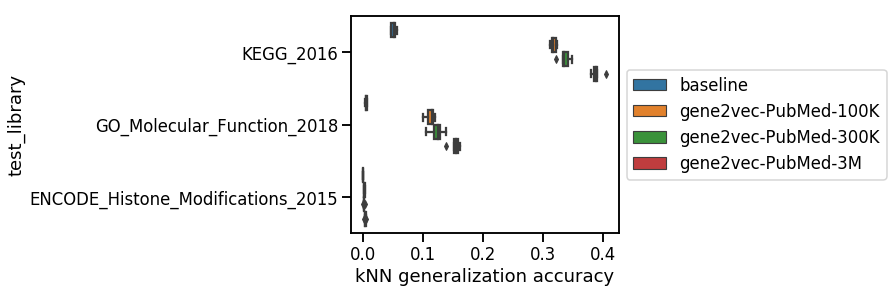

In [41]:
ax = sns.boxplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
ax.set_xlabel('kNN generalization accuracy')
# ax.set_xlim([-0.05, 1]);
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

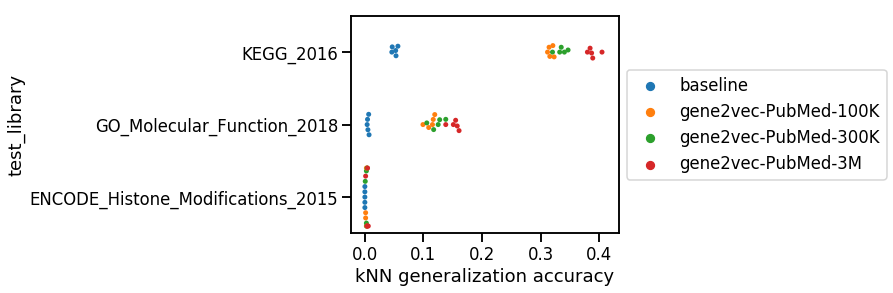

In [42]:
ax = sns.swarmplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
ax.set_xlabel('kNN generalization accuracy')
# ax.set_xlim([-0.05, 1]);
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));